# Forecasting Techniques 2: AutoARIMA

In the last notebook, we went over how to use ARIMA to forecast data in python. However in the ETL Pipeline, we will not be able to examine charts or select ARIMA models and their parameters. Instead, the pipeline needs to transform the data into forecasts on the fly, using automated forecasting techniques.

Enter AutoARIMA, a model designed to select the correct ARIMA model on the fly. Instead of selecting the model manually, we can use [Nixtla's AutoARIMA](<https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html#table-of-contents>) model instead to have the program select the correct model on the fly.

In this notebook, we will forecast weather data from the RegionWeather class using the AutoARIMA model, and evaluate its performance if possible

## 1. Importing Packages and Data

In [27]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from backend.regionweather import RegionWeather

region_data = {
    'US-FLA-FMPP': {'lat': 28.525581, 'lon': -81.536775, 'alt': 0},
    'US-FLA-FPC': {'lat': 28.996695, 'lon': -82.886613, 'alt': 0},
    'US-FLA-FPL': {'lat': 27.917488, 'lon': -81.450970, 'alt': 0},
    'US-FLA-GVL': {'lat': 29.619310, 'lon': -82.328732, 'alt': 0},
    'US-FLA-HST': {'lat': 25.456904, 'lon': -80.588092, 'alt': 0},
    'US-FLA-JEA': {'lat': 30.390902, 'lon': -83.679837, 'alt': 0},
    'US-FLA-SEC': {'lat': 28.805983, 'lon': -82.306291, 'alt': 0},
    'US-FLA-TAL': {'lat': 30.437174, 'lon': -84.248042, 'alt': 0},
    'US-FLA-TEC': {'lat': 27.959413, 'lon': -82.144821, 'alt': 0}
}

In [28]:
region = 'US-FLA-FMPP'
region1 = region_data['US-FLA-FMPP']
end = dt.datetime.today()
start = end - dt.timedelta(days=365)

rw = RegionWeather(region, region1['lat'],region1['lon'],region1['alt'],start,end)

Fetching Hourly Object...
Hourly Object Fetched!
Fetching Hourly Data from Object...
Hourly Object Fetched!
Hourly Data Cleaned!
Fetching Daily Data...
Daily Data Fetched!
Fetching Weekly Data...
Weekly Data Aggregated and Fetched!
Fetching Monthly Data...
Fetching Daily Data...
Monthly Data Fetched!
15 Minute Data Interpolated!


In [29]:
rw_dict = rw.to_dict()

temp = rw_dict['df_hourly']['temp'].reset_index().dropna()
temp.columns = ['ds','y']
temp['unique_id'] = '1'
temp

,ds,y,unique_id
0,2024-03-28 15:00:00,20.8,1
1,2024-03-28 16:00:00,21.9,1
2,2024-03-28 17:00:00,22.4,1
3,2024-03-28 18:00:00,23.5,1
4,2024-03-28 19:00:00,25.8,1
...,...,...,...
8755,2025-03-28 10:00:00,16.6,1
8756,2025-03-28 11:00:00,16.4,1
8757,2025-03-28 12:00:00,16.9,1
8758,2025-03-28 13:00:00,19.3,1


In [30]:
rw_dict['df_hourly'].columns.tolist()

['temp',
 'dwpt',
 'rhum',
 'prcp',
 'snow',
 'wdir',
 'wspd',
 'wpgt',
 'pres',
 'tsun',
 'coco']

In [31]:
wdir = rw_dict['df_hourly']['wdir'].reset_index().dropna()
wdir.columns = ['ds','y']
wdir['unique_id'] = '2'
wdir

,ds,y,unique_id
0,2024-03-28 15:00:00,310.0,2
1,2024-03-28 16:00:00,300.0,2
2,2024-03-28 17:00:00,330.0,2
3,2024-03-28 18:00:00,320.0,2
4,2024-03-28 19:00:00,330.0,2
...,...,...,...
8755,2025-03-28 10:00:00,94.0,2
8756,2025-03-28 11:00:00,91.0,2
8757,2025-03-28 12:00:00,85.0,2
8758,2025-03-28 13:00:00,77.0,2


Now we have finished collecting our data. We will start by forecasting with the `temp` (temperature) data.

## Forecasting with AutoARIMA

We can now import the AutoARIMA model in `statsmodels` to forecast our data.

### Investigating the Time Series

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (40,10)

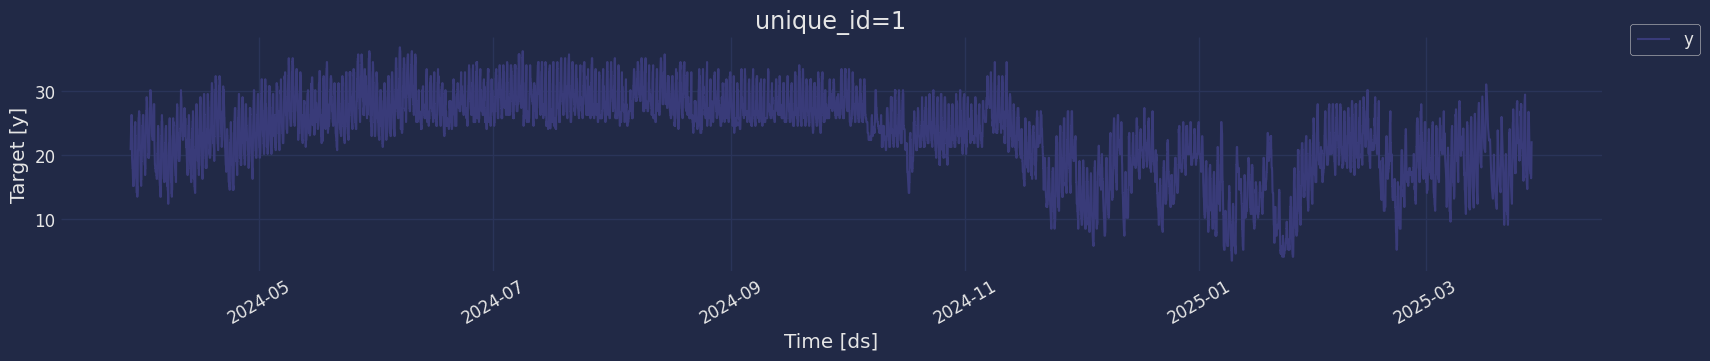

In [33]:
from statsforecast import StatsForecast

StatsForecast.plot(temp)

Here is our time series plot of temperature over the last year. Let's take a look at the autocorrelation plots (ACF/PACF) and the ADF test to see if the time series is stationary.

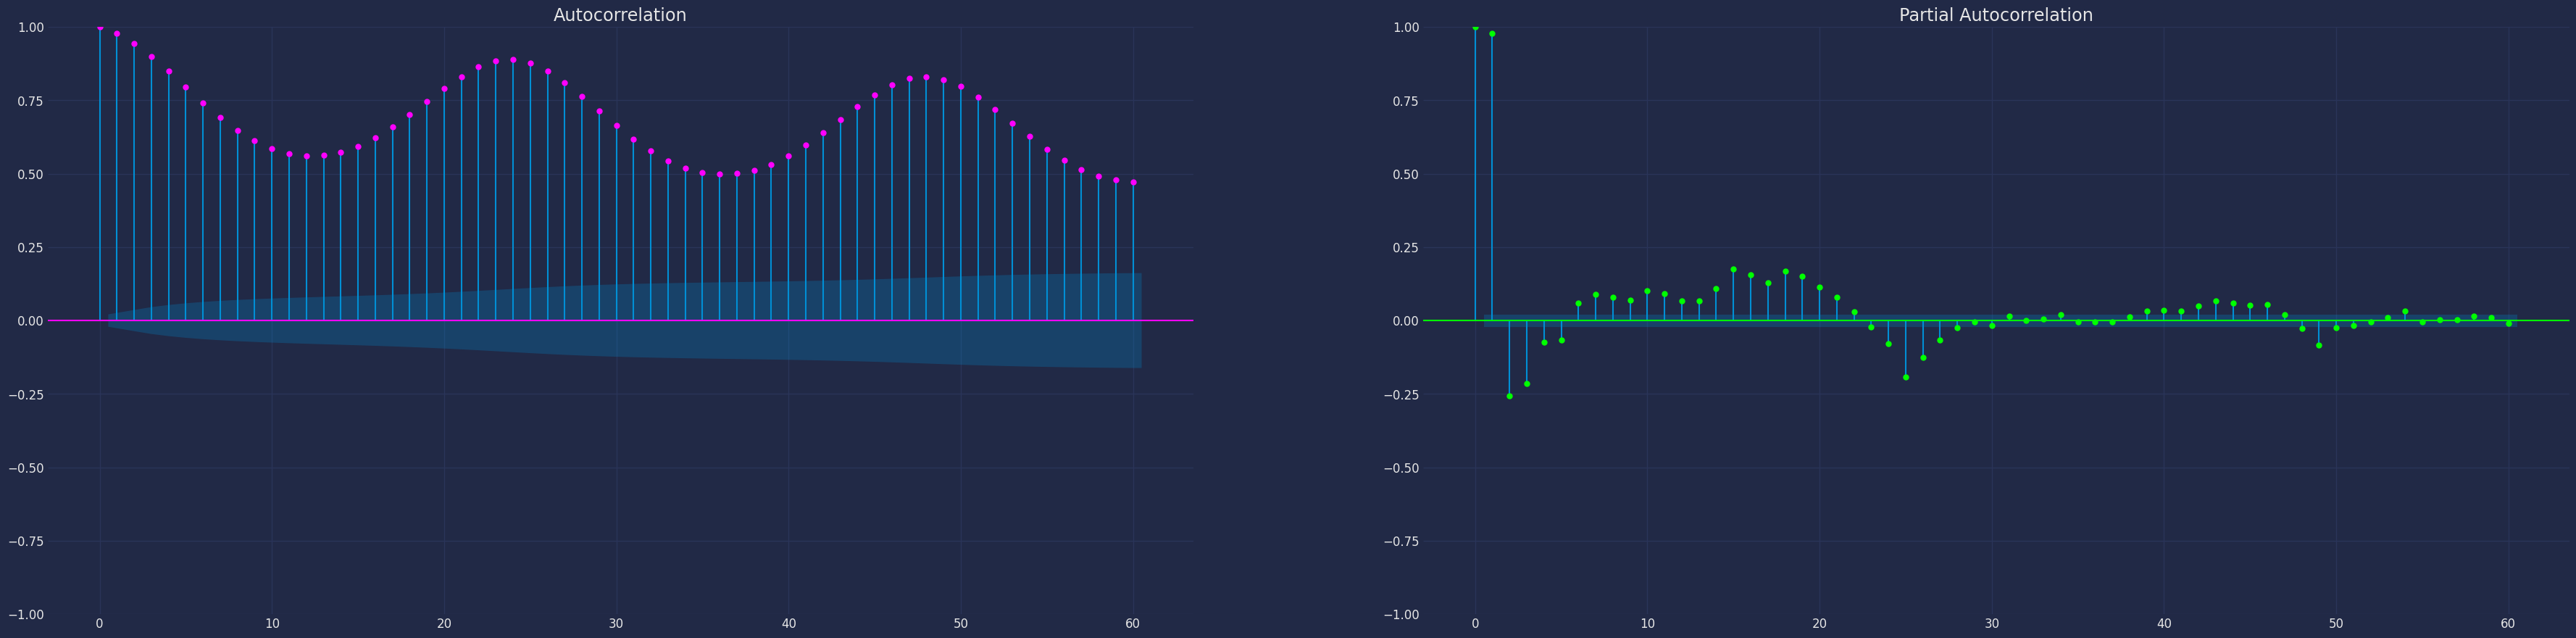

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(temp["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(temp["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

In [38]:
from statsmodels.tsa.stattools import adfuller
x = adfuller(temp["y"])

print(f'ADF Statistic: {x[0]}')
print(f'p-value: {x[1]}')


ADF Statistic: -4.642971550276921
p-value: 0.00010755417930980845


From the ADF test, we see a very small p-value, indicating we can reject the null hypothesis, and the time series is stationary(I think...?)

We can also decompose the time series into components and plot them to separate the seasonality.

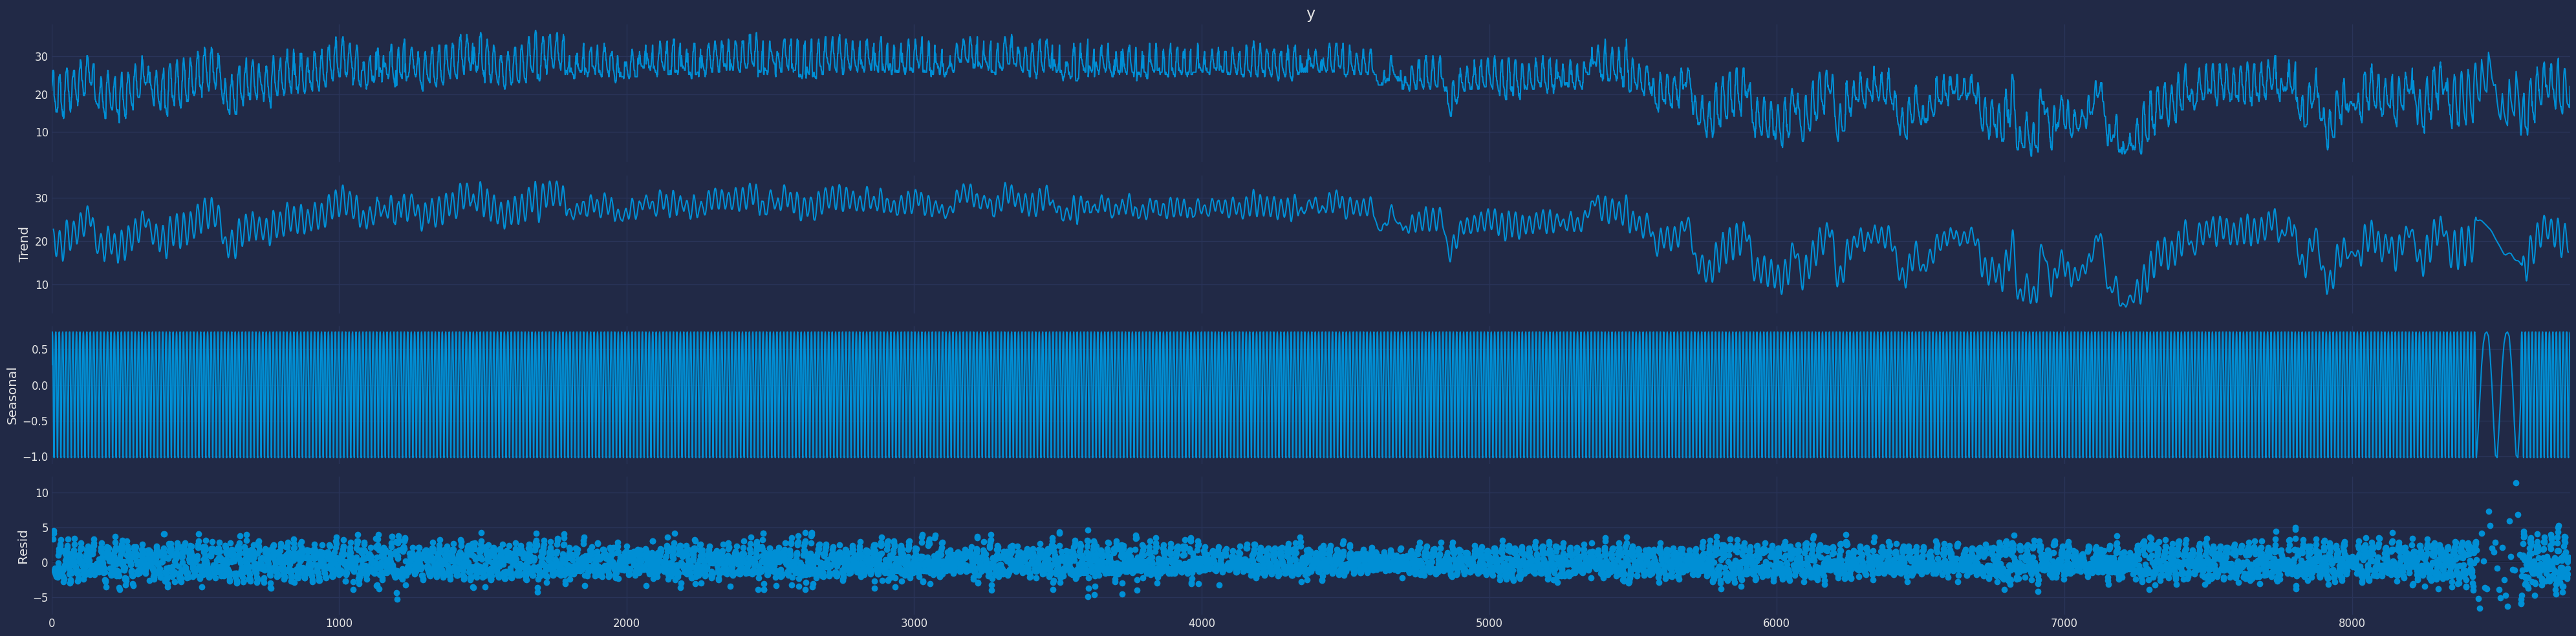

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(temp["y"], model = "add", period=12)
a.plot();

In [40]:
# Split into train/test sets
# Use 80% for training
split_point = int(len(temp) * 0.8)

train = temp[:split_point]
test = temp[split_point:]

print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")


Training set size: 6905
Test set size: 1727


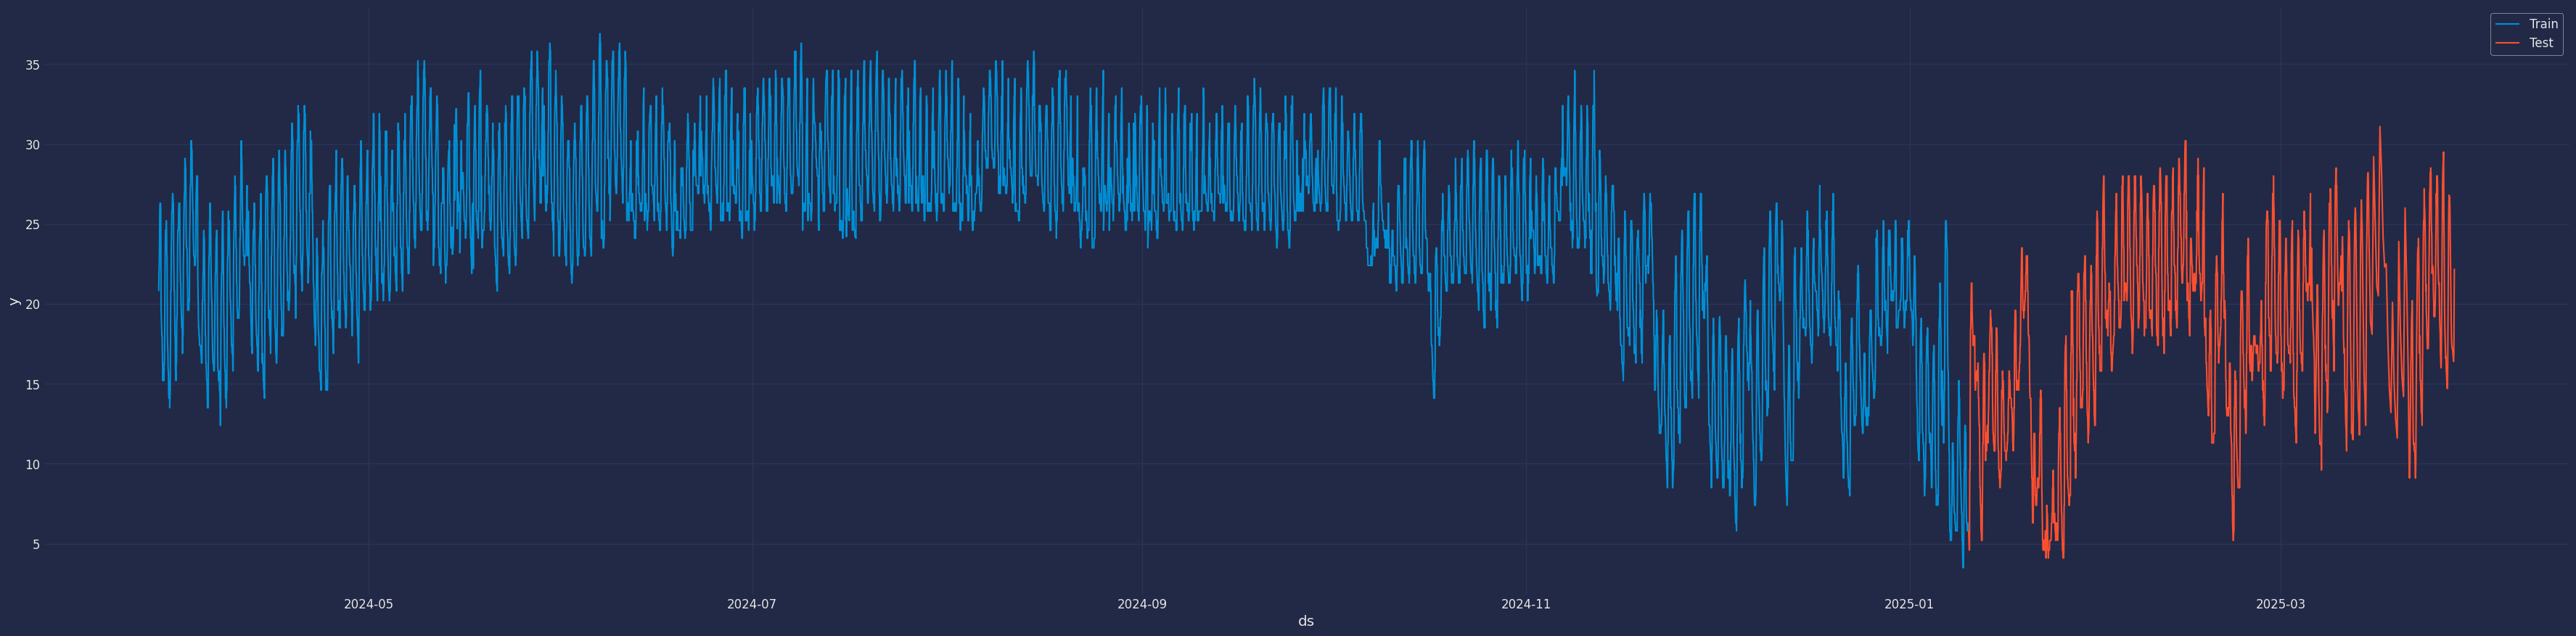

In [41]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

### Forecasting with AutoARIMA

In [42]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [44]:
season_length = 12 # Monthly data 
horizon = len(test) # number of predictions

models = [AutoARIMA(season_length=season_length)]

In [47]:
sf = StatsForecast(models=models, freq='MS')
sf.fit(df=train)

StatsForecast(models=[AutoARIMA])

In [49]:
StatsForecast(models=[AutoARIMA], freq='MS')

StatsForecast(models=[<class 'statsforecast.models.AutoARIMA'>])

In [50]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(3,1,1)(2,0,0)[12]                   '

The AutoARIMA model returned the value `ARIMA(3,1,1)(2,0,0)[12]`. What does this mean?

From the model, we have $p=3$, indicating a **non-seasonal, autoregressive element**. The model also has a **seasonal component of the order $d=1$**, and $q=1$, which contains **a 1 moving average element**.

We can now find the values of the terms of the values using the following statement.

In [51]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(3, 1, 2, 0, 12, 1, 0)


Now let's visualize the predictions.

In [52]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,0.020800
1,0.979638
2,0.455340
3,0.903306
4,2.082243
...,...
6900,-0.279600
6901,-0.412246
6902,0.286331
6903,-0.482445



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



NameError: name 'stats' is not defined

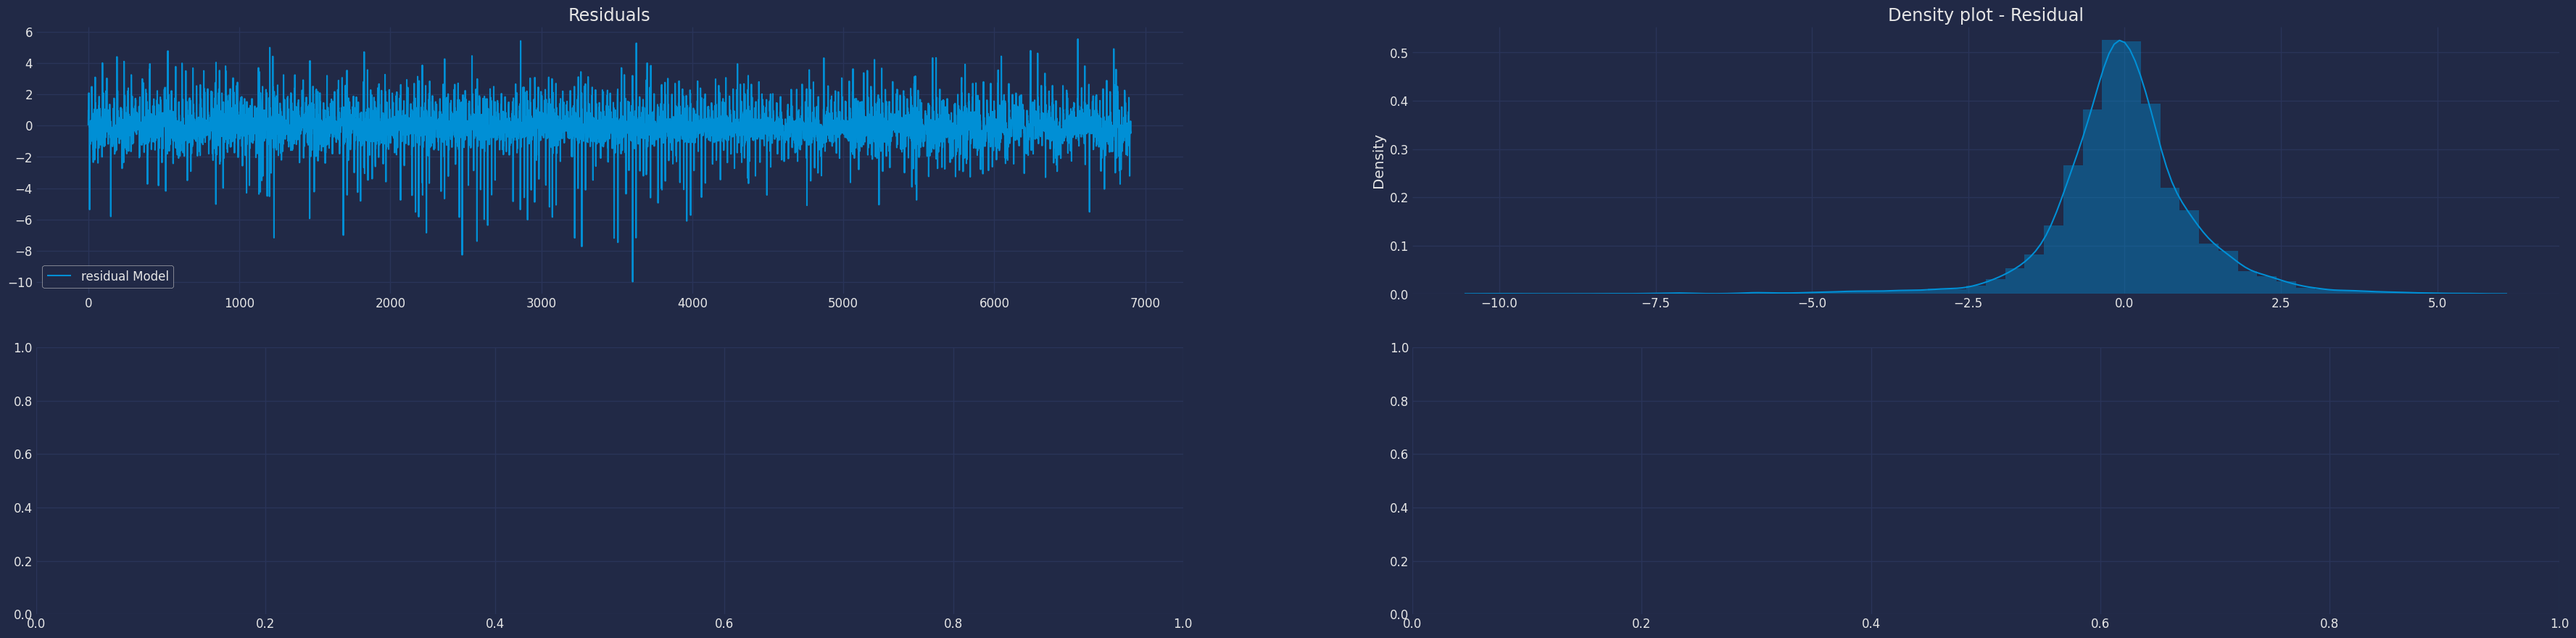

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();